In [17]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import src.relabel_data as rd
import cv2
import numpy as np
from src.create_augement import createAugment
import matplotlib.image as mpimg
from keras.utils import CustomObjectScope
from keras.models import load_model
from PIL import Image, ImageDraw
import random

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# get the new data after filtering and relabeling
x_train, y_train, x_test, y_test = rd.filter_relabel(x_train, y_train, x_test, y_test)

train_masked = createAugment(x_train, x_train)
test_masked = createAugment(x_test, x_test)

In [12]:
train_masked = createAugment(x_train, x_train)
test_masked = createAugment(x_test, x_test)

In [13]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [14]:
def unet_improved():
    inputs = keras.layers.Input((32, 32, 3))

    # Encoding / Downsampling
    conv1 = keras.layers.Conv2D(64, (3, 3), activation=keras.layers.LeakyReLU(), padding='same')(inputs)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(0.1)(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(128, (3, 3), activation=keras.layers.LeakyReLU(), padding='same')(pool1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(0.1)(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = keras.layers.Conv2D(256, (3, 3), activation=keras.layers.LeakyReLU(), padding='same')(pool2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(0.1)(conv3)

    # Decoding / Upsampling
    up4 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    conv4 = keras.layers.Conv2D(128, (3, 3), activation=keras.layers.LeakyReLU(), padding='same')(up4)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.Dropout(0.1)(conv4)

    up5 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=3)
    conv5 = keras.layers.Conv2D(64, (3, 3), activation=keras.layers.LeakyReLU(), padding='same')(up5)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.Dropout(0.1)(conv5)

    # Output
    outputs = keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(conv5)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])

In [15]:
keras.backend.clear_session()
model = unet_improved()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In [27]:
# run on server
model.fit(train_masked, validation_data=test_masked, 
        epochs=200, 
        steps_per_epoch=len(train_masked), 
        validation_steps=len(test_masked),
        use_multiprocessing=True, callbacks=[early_stopping])

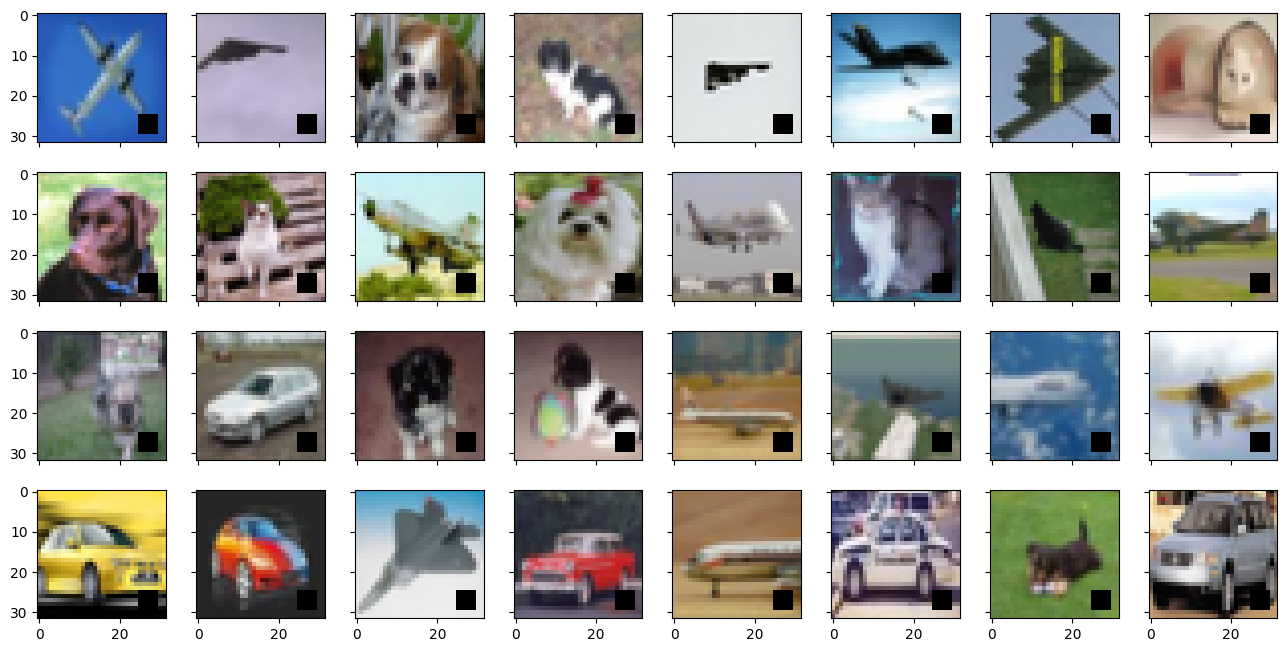

In [18]:
## Examples
random.seed(888)
sample_idx = 100 ## Change this to see different batches

sample_images, sample_labels = train_masked[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

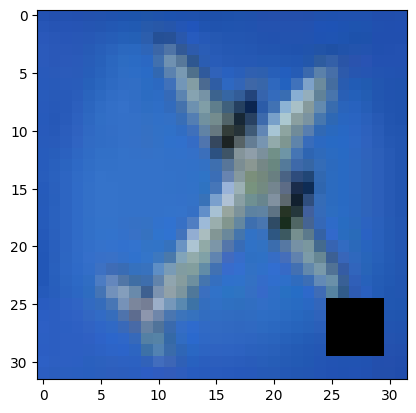

In [24]:
plt.imshow(sample_images[0])

In [28]:
# Load the model
with CustomObjectScope({'dice_coef': dice_coef}):
    model = load_model('improved_Unet.h5')

1/1 [==============================] - 0s 92ms/step


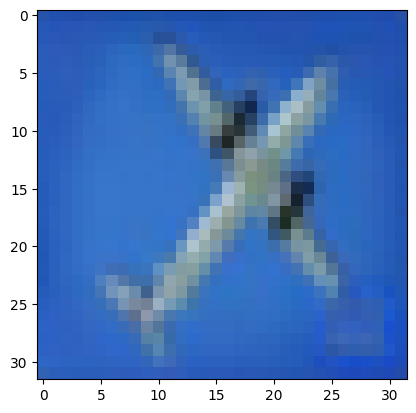

In [29]:
im = sample_images[0]
impainted_image = model.predict(im.reshape((1,)+im.shape))
plt.imshow(impainted_image.reshape(impainted_image.shape[1:]))

1/1 [==============================] - 0s 11ms/step


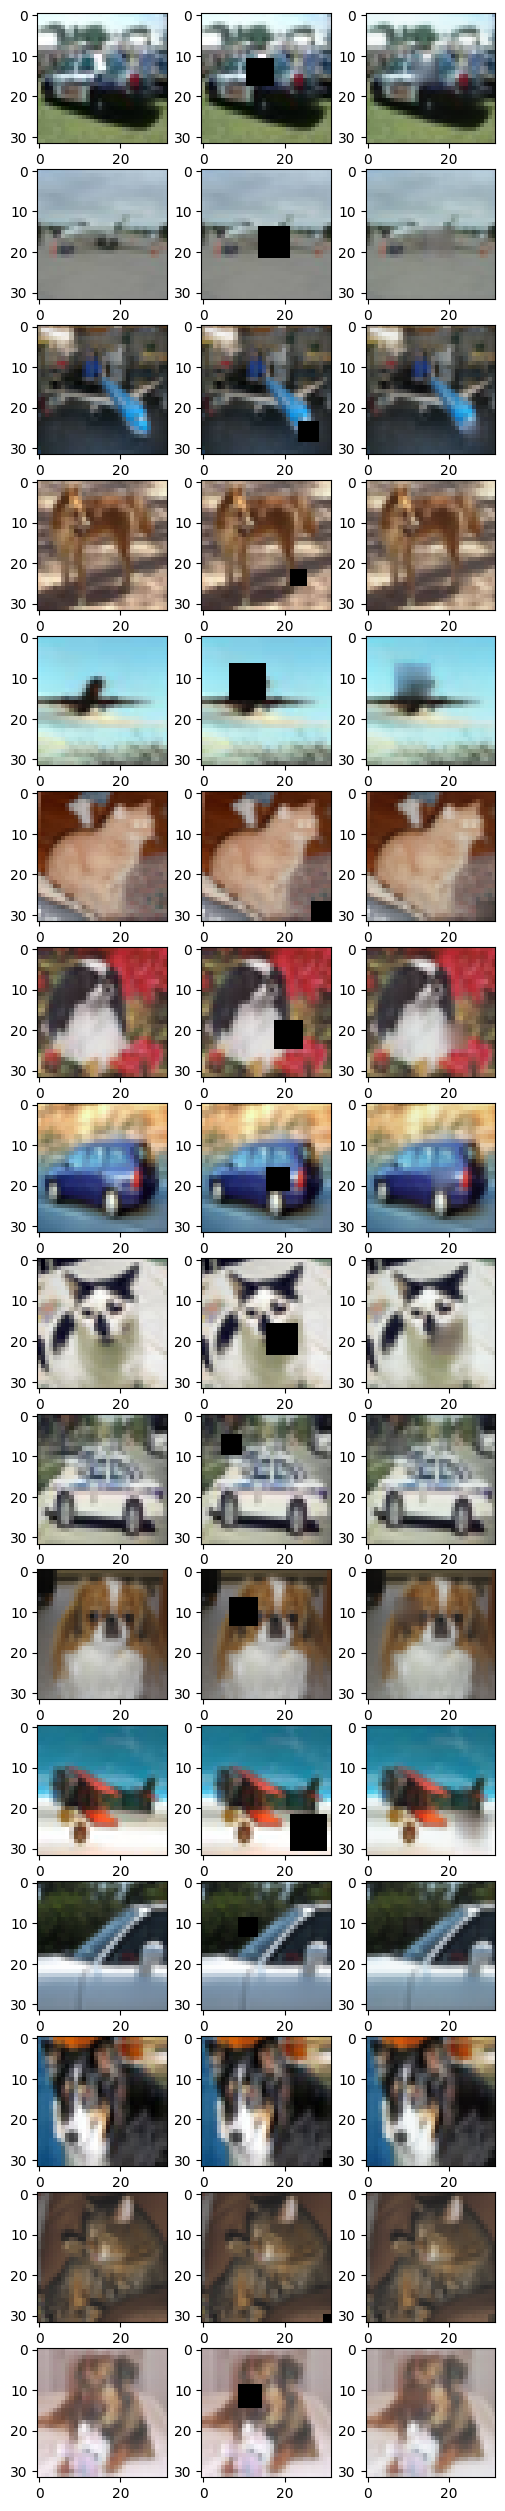

In [30]:
## Examples
rows = 16
sample_idx = np.random.randint(0, len(test_masked), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  sample_images, sample_labels = train_masked[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx])
  axs[i][1].imshow(sample_images[img_idx])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

1/1 [==============================] - 0s 15ms/step


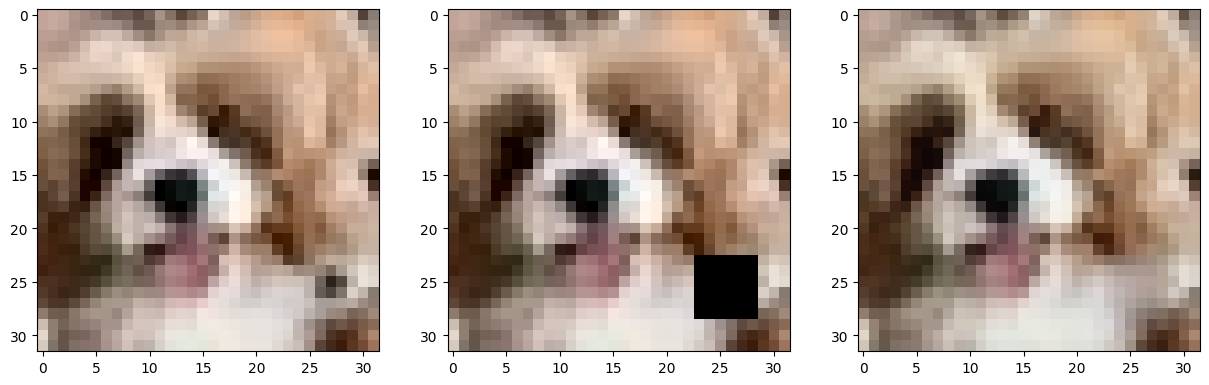

In [36]:
#Load the resized the image for testing
img_resized = Image.open('test_resized.jpg')
img_resized = np.array(img_resized)

test_dog = img_resized.reshape((1,)+img_resized.shape)

# Add mask to the picture
test_dog_masked = createAugment(test_dog, test_dog)
test_dog_image, test_dog_labels = test_dog_masked[0]

# Fit the model
img_resized_pred = model.predict(test_dog_image[0].reshape((1,)+test_dog_image[0].shape))

# Plot the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(img_resized)
axs[1].imshow(test_dog_image[0])
axs[2].imshow(img_resized_pred.reshape(img_resized_pred.shape[1:]))

plt.show()

In [35]:
def resize_image(input_image_path, output_image_path, size):
    original_image = Image.open(input_image_path)
    width, height = original_image.size
    print(f'The original image size is {width} wide x {height} tall')

    resized_image = original_image.resize(size)
    width, height = resized_image.size
    print(f'The resized image size is {width} wide x {height} tall')
    #resized_image.show()
    resized_image.save(output_image_path)

# Call the function
resize_image('jiusi.jpeg', 'jiusi_resized.jpeg', (32, 32))

The original image size is 642 wide x 642 tall
The resized image size is 32 wide x 32 tall


1/1 [==============================] - 0s 13ms/step


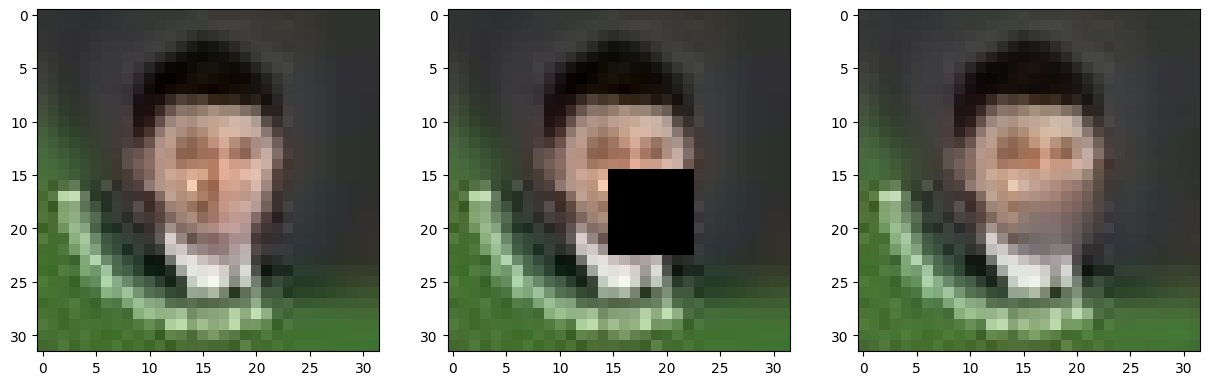

In [39]:
#Load the resized the image for testing
img_resized = Image.open('jiusi_resized.jpeg')
img_resized = np.array(img_resized)

test_dog = img_resized.reshape((1,)+img_resized.shape)

# Add mask to the picture
test_dog_masked = createAugment(test_dog, test_dog)
test_dog_image, test_dog_labels = test_dog_masked[0]

# Fit the model
img_resized_pred = model.predict(test_dog_image[0].reshape((1,)+test_dog_image[0].shape))

# Plot the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(img_resized)
axs[1].imshow(test_dog_image[0])
axs[2].imshow(img_resized_pred.reshape(img_resized_pred.shape[1:]))

plt.show()

The original image size is 260 wide x 294 tall
The resized image size is 32 wide x 32 tall
1/1 [==============================] - 0s 12ms/step


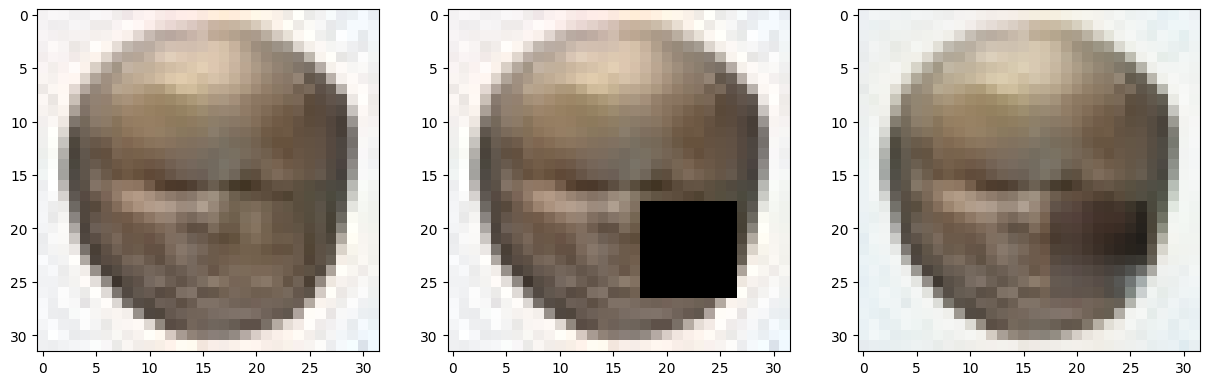

In [54]:
resize_image('tudou.jpg', 'tudou_resize.jpg', (32, 32))

#Load the resized the image for testing
img_resized = Image.open('tudou_resize.jpg')
img_resized = np.array(img_resized)

test_dog = img_resized.reshape((1,)+img_resized.shape)

# Add mask to the picture
test_dog_masked = createAugment(test_dog, test_dog)
test_dog_image, test_dog_labels = test_dog_masked[0]

# Fit the model
img_resized_pred = model.predict(test_dog_image[0].reshape((1,)+test_dog_image[0].shape))

# Plot the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(img_resized)
axs[1].imshow(test_dog_image[0])
axs[2].imshow(img_resized_pred.reshape(img_resized_pred.shape[1:]))

plt.show()